In [282]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
from datetime import date
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# no warnings
import warnings
warnings.filterwarnings('ignore')

In [283]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
label = "priceRange"

In [284]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(TEST_PATH)

In [285]:
train.head(1)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,MULTIPLE OFFERS submit best & final to Agent b...,Single Family,30.380089,-97.800621,0,False,1988,0,102366.0,7.0,17,4.0,4,650000+


In [286]:
train.shape

(10000, 16)

In [287]:
classes = train[label].unique().tolist()
print(f"Label classes: {classes}")

train[label] = train[label].map(classes.index)

Label classes: ['650000+', '350000-450000', '0-250000', '450000-650000', '250000-350000']


In [288]:
train.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange'],
      dtype='object')

In [289]:
test.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms'],
      dtype='object')

# Train

In [290]:
train.description

0       MULTIPLE OFFERS submit best & final to Agent b...
1       4644 Hoffman Dr, Austin, TX 78749 is a single ...
2       6804 Canal St, Austin, TX 78741 is a single fa...
3       Beautiful large lot with established trees. Lo...
4       Stunning NW Hills designer remodel by Cedar an...
                              ...                        
9995    Updated Great Hills Opportunity! Large corner ...
9996    Adorable 3/2 in the heart of South Austin! Sit...
9997    7322 Gaines Mill Ln, Austin, TX 78745 is a sin...
9998    5213 Doe Valley Ln, Austin, TX 78759 is a sing...
9999    Beautiful single-story home with open floor pl...
Name: description, Length: 10000, dtype: object

In [291]:
def inpute_missing(dataset):
    """ 
    Edit this to fix nulls. Default version replaces all int/float with 0
    """
    for col in dataset.columns:
        if dataset[col].dtype not in [str, object]:
            dataset[col] = dataset[col].fillna(dataset[col].mean())
        elif col == 'name':
             dataset[col] = 'No Name'
    return dataset

train = inpute_missing(train)
test = inpute_missing(test)

In [292]:
def nlp_transforms(dataset):
    """ 
    NLP tranforms here. Default, None...
    """
    
    # lower case
    dataset['description'] = dataset['description'].str.lower()
    
    #remove punctuations
    train["description"] = train['description'].str.replace('[^\w\s]','')
    
    return dataset

train = nlp_transforms(train)
test = nlp_transforms(test)

In [293]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uid                         10000 non-null  int64  
 1   city                        10000 non-null  object 
 2   description                 10000 non-null  object 
 3   homeType                    10000 non-null  object 
 4   latitude                    10000 non-null  float64
 5   longitude                   10000 non-null  float64
 6   garageSpaces                10000 non-null  int64  
 7   hasSpa                      10000 non-null  bool   
 8   yearBuilt                   10000 non-null  int64  
 9   numOfPatioAndPorchFeatures  10000 non-null  int64  
 10  lotSizeSqFt                 10000 non-null  float64
 11  avgSchoolRating             10000 non-null  float64
 12  MedianStudentsPerTeacher    10000 non-null  int64  
 13  numOfBathrooms              1000

In [294]:
def computation_transforms(dataset):
    """ 
    New Feature Engineering. Default, None...
    """
    dataset['hasSpa'] = np.where(dataset['hasSpa'] == True, "yes", "no")
    return dataset

train = computation_transforms(train)
test = computation_transforms(test)

# Train

In [295]:
train.head(1)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
0,1748,austin,multiple offers submit best final to agent by...,Single Family,30.380089,-97.800621,0,0,1988,0,102366.0,7.0,17,4.0,4,0


In [296]:
train.columns

Index(['uid', 'city', 'description', 'homeType', 'latitude', 'longitude',
       'garageSpaces', 'hasSpa', 'yearBuilt', 'numOfPatioAndPorchFeatures',
       'lotSizeSqFt', 'avgSchoolRating', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'priceRange'],
      dtype='object')

In [297]:
to_drop = ['uid']
train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

In [298]:
columns = train.columns.tolist()

In [299]:
columns

['city',
 'description',
 'homeType',
 'latitude',
 'longitude',
 'garageSpaces',
 'hasSpa',
 'yearBuilt',
 'numOfPatioAndPorchFeatures',
 'lotSizeSqFt',
 'avgSchoolRating',
 'MedianStudentsPerTeacher',
 'numOfBathrooms',
 'numOfBedrooms',
 'priceRange']

In [347]:
def prepare_dataset(data):
    
    features = {#"city" : data["city"],
                #"description" : tf.strings.split(data["description"]),
                #"homeType" : data["homeType"],
                "latitude" : data["latitude"],
                "longitude" : data["longitude"],
                #"garageSpaces" : data["garageSpaces"],
                #"hasSpa" : data["hasSpa"],
                #"yearBuilt" : data["yearBuilt"],
                #"numOfPatioAndPorchFeatures" : data["numOfPatioAndPorchFeatures"],
                "lotSizeSqFt" : data["lotSizeSqFt"],
                #"avgSchoolRating" : data["avgSchoolRating"],
                #"MedianStudentsPerTeacher" : data["MedianStudentsPerTeacher"],
                "numOfBathrooms" : data["numOfBathrooms"],
                "numOfBedrooms" : data["numOfBedrooms"]
               }
    
    try:
        label = data['priceRange']
        output = features,label
    except:
        output = features
    
    return output

In [339]:
X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

columns = train.columns.tolist()
#columns = ['age','outcome_type']
train_dataframe = X_train[columns]
train_dataframe = train_dataframe.to_dict('list')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataframe)

test_dataframe = X_test[columns]
test_dataframe = test_dataframe.to_dict('list')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataframe)



train_ds = train_dataset.batch(64).map(prepare_dataset)
test_ds = test_dataset.batch(64).map(prepare_dataset)

In [340]:
#train.head()

In [342]:
model_1 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_1.compile(metrics=["accuracy"])
model_1.fit(x=train_ds)

125/125 [==============================] - 0s 579us/step


In [343]:
#logs

In [345]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.3562341034412384, loss=1.5625983476638794, rmse=None, ndcg=None, aucs=None)

In [346]:
# only breed
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

32/32 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4445
BinaryCrossentropyloss: 0.0
Accuracy: 0.44449999928474426


In [277]:
#model_1.summary()

In [278]:
#tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=2)

In [130]:
#logs loss

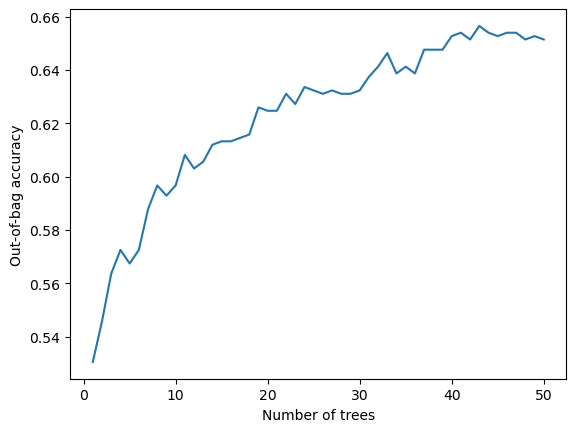

In [240]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
plt.show()

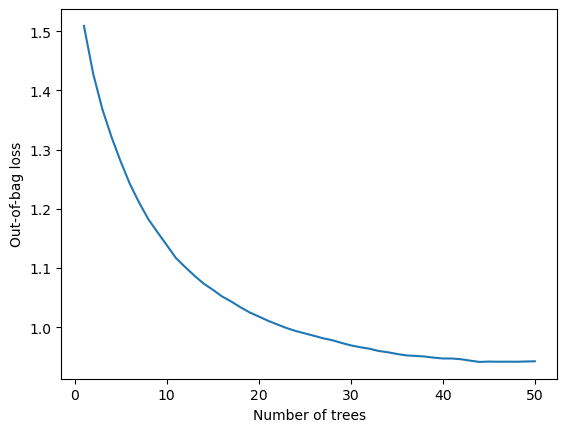

In [241]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

In [242]:
test_ds

<MapDataset shapes: ({city: (None,), homeType: (None,), latitude: (None,), longitude: (None,), garageSpaces: (None,), hasSpa: (None,), yearBuilt: (None,), numOfPatioAndPorchFeatures: (None,), lotSizeSqFt: (None,), avgSchoolRating: (None,), MedianStudentsPerTeacher: (None,), numOfBathrooms: (None,), numOfBedrooms: (None,)}, (None,)), types: ({city: tf.string, homeType: tf.string, latitude: tf.float32, longitude: tf.float32, garageSpaces: tf.int32, hasSpa: tf.int32, yearBuilt: tf.int32, numOfPatioAndPorchFeatures: tf.int32, lotSizeSqFt: tf.float32, avgSchoolRating: tf.float32, MedianStudentsPerTeacher: tf.int32, numOfBathrooms: tf.float32, numOfBedrooms: tf.int32}, tf.int32)>

In [243]:
train_ds

<MapDataset shapes: ({city: (None,), homeType: (None,), latitude: (None,), longitude: (None,), garageSpaces: (None,), hasSpa: (None,), yearBuilt: (None,), numOfPatioAndPorchFeatures: (None,), lotSizeSqFt: (None,), avgSchoolRating: (None,), MedianStudentsPerTeacher: (None,), numOfBathrooms: (None,), numOfBedrooms: (None,)}, (None,)), types: ({city: tf.string, homeType: tf.string, latitude: tf.float32, longitude: tf.float32, garageSpaces: tf.int32, hasSpa: tf.int32, yearBuilt: tf.int32, numOfPatioAndPorchFeatures: tf.int32, lotSizeSqFt: tf.float32, avgSchoolRating: tf.float32, MedianStudentsPerTeacher: tf.int32, numOfBathrooms: tf.float32, numOfBedrooms: tf.int32}, tf.int32)>

In [244]:
# all features
#model_1.evaluate(test_ds)

#print(f"BinaryCrossentropyloss: {evaluation[0]}")
#print(f"Accuracy: {evaluation[1]}")


In [245]:
#model_1.summary()

In [263]:
# only breed
#evaluation = model_1.evaluate(test_ds)

#print(f"BinaryCrossentropyloss: {evaluation[0]}")
#print(f"Accuracy: {evaluation[1]}")

In [264]:
## Old Model
evaluation

0.0

In [265]:
evaluation

0.0

# Train on Entire Dataset


In [317]:
columns = train.columns.tolist()
train_dataframe = train[columns]
train_dataframe = train_dataframe.to_dict('list')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataframe)
train_ds = train_dataset.batch(64).map(prepare_dataset)

model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model.compile()
model.fit(x=train_ds)

125/125 [==============================] - 0s 864us/step


In [318]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.4872773587703705, loss=1.5270057916641235, rmse=None, ndcg=None, aucs=None)

In [337]:
model_1.summary()

Model: "gradient_boosted_trees_model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (14):
	MedianStudentsPerTeacher
	avgSchoolRating
	city
	description
	garageSpaces
	hasSpa
	homeType
	latitude
	longitude
	lotSizeSqFt
	numOfBathrooms
	numOfBedrooms
	numOfPatioAndPorchFeatures
	yearBuilt

No weights

Variable Importance: NUM_NODES:
    1.                "description" 5505.000000 ################
    2.   "MedianStudentsPerTeacher" 1004.000000 ##
    3.                   "latitude" 926.000000 ##
    4.            "avgSchoolRating" 907.000000 ##
    5.                "lotSizeSqFt" 673.000000 #
    6.                  "longitude" 641.000000 #
    7.               "garageSpaces" 594.000000 #
    

# Predictions

In [319]:
columns = test.columns.tolist()
test_dataframe = test[columns]
test_dataframe = test_dataframe.to_dict('list')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataframe)
test_ds = test_dataset.batch(64).map(prepare_dataset)

In [320]:
scores = model.predict(test_ds)

In [321]:
#Label classes: ['adoption', 'no outcome', 'transfer']

In [322]:
scores

array([[0.0022705 , 0.0126286 , 0.94026744, 0.00292047, 0.04191303],
       [0.06569017, 0.15802495, 0.2453018 , 0.2842607 , 0.24672236],
       [0.01091495, 0.1287469 , 0.249511  , 0.02858297, 0.5822441 ],
       ...,
       [0.00453154, 0.04765286, 0.3798967 , 0.00752358, 0.56039524],
       [0.00780663, 0.27257222, 0.02993951, 0.02511302, 0.66456866],
       [0.00694304, 0.7305793 , 0.01242512, 0.20013174, 0.04992074]],
      dtype=float32)

In [323]:
temp = pd.DataFrame(data=scores, columns=["0-250000", "250000-350000","350000-450000","450000-650000","650000+"])

In [324]:
#submission

In [325]:
temp['uid'] = submission.uid

In [326]:
temp

,0-250000,250000-350000,350000-450000,450000-650000,650000+,uid
0,0.002270,0.012629,0.940267,0.002920,0.041913,4070
1,0.065690,0.158025,0.245302,0.284261,0.246722,5457
2,0.010915,0.128747,0.249511,0.028583,0.582244,2053
3,0.034922,0.225240,0.013844,0.675906,0.050088,4723
4,0.070245,0.469009,0.052660,0.277164,0.130922,5417
...,...,...,...,...,...,...
4956,0.011001,0.210182,0.406332,0.053638,0.318847,4284
4957,0.026155,0.241252,0.076762,0.126302,0.529528,2945
4958,0.004532,0.047653,0.379897,0.007524,0.560395,12334
4959,0.007807,0.272572,0.029940,0.025113,0.664569,240


In [327]:
temp = temp[["uid","0-250000", "250000-350000","350000-450000","450000-650000","650000+"]]

In [328]:
temp

,uid,0-250000,250000-350000,350000-450000,450000-650000,650000+
0,4070,0.002270,0.012629,0.940267,0.002920,0.041913
1,5457,0.065690,0.158025,0.245302,0.284261,0.246722
2,2053,0.010915,0.128747,0.249511,0.028583,0.582244
3,4723,0.034922,0.225240,0.013844,0.675906,0.050088
4,5417,0.070245,0.469009,0.052660,0.277164,0.130922
...,...,...,...,...,...,...
4956,4284,0.011001,0.210182,0.406332,0.053638,0.318847
4957,2945,0.026155,0.241252,0.076762,0.126302,0.529528
4958,12334,0.004532,0.047653,0.379897,0.007524,0.560395
4959,240,0.007807,0.272572,0.029940,0.025113,0.664569


In [329]:
#temp['no outcome'] = np.where(temp['no outcome'] > .96, 1, temp['no outcome'])
#temp['adoption'] = np.where(temp['no outcome'] == 1, 0, temp['adoption'])
#temp['transfer'] = np.where(temp['no outcome'] == 1, 0, temp['transfer'])

In [330]:
#temp['adoption'] = np.where(temp['adoption'] > .96, 1, temp['adoption'])
#temp['no outcome'] = np.where(temp['adoption'] == 1, 0, temp['no outcome'])
#temp['transfer'] = np.where(temp['adoption'] == 1, 0, temp['transfer'])

In [331]:
#temp['transfer'] = np.where(temp['transfer'] > .96, 1, temp['transfer'])
#temp['adoption'] = np.where(temp['transfer'] == 1, 0, temp['adoption'])
#temp['no outcome'] = np.where(temp['transfer'] == 1, 0, temp['no outcome'])

In [332]:
temp.to_csv('submission.csv', index=False)

In [333]:
!kaggle competitions submit -c sliced-s01e11-semifinals -f submission.csv -m "bag of words"

100%|█████████████████████████████████████████| 299k/299k [00:00<00:00, 363kB/s]
Successfully submitted to SLICED s01e11, Semifinals